In [112]:
import ast
# note this is python2 compatible only. the pykriging code is also python2 only
import urllib2
import urllib
from cStringIO import StringIO
from scipy.spatial.distance import pdist, squareform
import json
import geopandas as gpd
import pandas as pd
import os
import zipfile
import numpy as np
import pylab as pl
import seaborn

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
SQL_SOURCE = 'https://fb55.carto.com/api/v2/sql'

def queryCartoDB(query, format = 'CSV', source = SQL_SOURCE):
    """ queries a url with an sql compatible search
    Arguments:
    query : the sql query string
    format : the expected format
    source " the url of the API
    """
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

In [3]:
facilityQuery = '''
SELECT zipcodes, count(*)
FROM nycasthmasdismissals
GROUP BY zipcodes
'''

In [4]:
# fill in the query details in facilityQuery: 
# within a single query collect AND GROUP the data by zipcode

facilityStream = queryCartoDB(facilityQuery, format='JSON')
facilityData = json.loads(facilityStream.read())
facilities = pd.DataFrame.from_dict(facilityData['rows'])
facilities.head()

,count,zipcodes
0,1699,10461
1,405,11373
2,1698,10451
3,220,11691
4,246,11375


In [5]:
facilities.shape

(29, 2)

In [22]:
facilities.dtypes

count       int64
zipcodes    int64
dtype: object

#### Downloading NYC zipcode shapefiles 

In [6]:
print os.getenv("PUIDATA")

/home/cusp/as10790/PUIdata


In [8]:
file_path = 'https://data.cityofnewyork.us/api/file_data/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip'
file_name = 'YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip'

In [11]:
!curl -O https://data.cityofnewyork.us/api/file_data/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1478k  100 1478k    0     0  1315k      0  0:00:01  0:00:01 --:--:-- 1756k


In [12]:
os.system("mv " + file_name + ' ' + os.getenv("PUIDATA"))

0

In [14]:
zip_ref = zipfile.ZipFile(os.getenv('PUIDATA') + '/' + file_name, 'r')
zip_ref.extractall(os.getenv('PUIDATA'))
zip_ref.close

<bound method ZipFile.close of <zipfile.ZipFile object at 0x7fa4e5856b10>>

In [15]:
zip_shapes = gpd.GeoDataFrame.from_file(os.getenv('PUIDATA') + '/' + "ZIP_CODE_040114.shp")

In [16]:
zip_shapes.head()

,AREA,BLDGZIP,COUNTY,CTY_FIPS,POPULATION,PO_NAME,SHAPE_AREA,SHAPE_LEN,STATE,ST_FIPS,URL,ZIPCODE,geometry
0,2.269930e+07,0,Queens,081,18681.0,Jamaica,0.0,0.0,NY,36,http://www.usps.com/,11436,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,2.963100e+07,0,Kings,047,62426.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11213,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,4.197210e+07,0,Kings,047,83866.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11212,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,2.369863e+07,0,Kings,047,56527.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11225,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,3.686880e+07,0,Kings,047,72280.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11218,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [27]:
zip_shapes.ZIPCODE = zip_shapes.ZIPCODE.astype(int)

In [29]:
# Merging facilities with zip codes
merged = facilities.merge(zip_shapes, left_on = 'zipcodes', right_on = 'ZIPCODE')

In [30]:
merged.head()

,count,zipcodes,AREA,BLDGZIP,COUNTY,CTY_FIPS,POPULATION,PO_NAME,SHAPE_AREA,SHAPE_LEN,STATE,ST_FIPS,URL,ZIPCODE,geometry
0,1699,10461,6.282406e+07,0,Bronx,005,50549.0,Bronx,0.0,0.0,NY,36,http://www.usps.com/,10461,"POLYGON ((1029230.779448971 251468.9475710541,..."
1,405,11373,4.265486e+07,0,Queens,081,101282.0,Elmhurst,0.0,0.0,NY,36,http://www.usps.com/,11373,"POLYGON ((1015508.538520813 204353.9663418829,..."
2,1698,10451,2.894411e+07,0,Bronx,005,44140.0,Bronx,0.0,0.0,NY,36,http://www.usps.com/,10451,"POLYGON ((1002809.989770979 240846.5980808884,..."
3,220,11691,8.392782e+07,0,Queens,081,60267.0,Far Rockaway,0.0,0.0,NY,36,http://www.usps.com/,11691,"POLYGON ((1054519.887991399 162245.7592198849,..."
4,246,11375,5.558777e+07,0,Queens,081,68555.0,Forest Hills,0.0,0.0,NY,36,http://www.usps.com/,11375,"POLYGON ((1024087.848133817 207717.1410459727,..."


In [32]:
merged.columns

Index([     u'count',   u'zipcodes',       u'AREA',    u'BLDGZIP',
           u'COUNTY',   u'CTY_FIPS', u'POPULATION',    u'PO_NAME',
       u'SHAPE_AREA',  u'SHAPE_LEN',      u'STATE',    u'ST_FIPS',
              u'URL',    u'ZIPCODE',   u'geometry'],
      dtype='object')

In [36]:
merged = gpd.GeoDataFrame(merged)

In [40]:
merged['centers'] = merged.geometry.centroid # Creating centroids of polygon shapes

In [41]:
merged.head()

,count,zipcodes,AREA,BLDGZIP,COUNTY,CTY_FIPS,POPULATION,PO_NAME,SHAPE_AREA,SHAPE_LEN,STATE,ST_FIPS,URL,ZIPCODE,geometry,centers
0,1699,10461,6.282406e+07,0,Bronx,005,50549.0,Bronx,0.0,0.0,NY,36,http://www.usps.com/,10461,"POLYGON ((1029230.779448971 251468.9475710541,...",POINT (1028292.72437689 247902.4282787614)
1,405,11373,4.265486e+07,0,Queens,081,101282.0,Elmhurst,0.0,0.0,NY,36,http://www.usps.com/,11373,"POLYGON ((1015508.538520813 204353.9663418829,...",POINT (1017941.215480481 208485.1046661779)
2,1698,10451,2.894411e+07,0,Bronx,005,44140.0,Bronx,0.0,0.0,NY,36,http://www.usps.com/,10451,"POLYGON ((1002809.989770979 240846.5980808884,...",POINT (1005358.961284301 238316.0675161843)
3,220,11691,8.392782e+07,0,Queens,081,60267.0,Far Rockaway,0.0,0.0,NY,36,http://www.usps.com/,11691,"POLYGON ((1054519.887991399 162245.7592198849,...",POINT (1050360.772370908 158235.4624321515)
4,246,11375,5.558777e+07,0,Queens,081,68555.0,Forest Hills,0.0,0.0,NY,36,http://www.usps.com/,11375,"POLYGON ((1024087.848133817 207717.1410459727,...",POINT (1026858.206454871 201880.2234817908)


In [42]:
merged.columns

Index([     u'count',   u'zipcodes',       u'AREA',    u'BLDGZIP',
           u'COUNTY',   u'CTY_FIPS', u'POPULATION',    u'PO_NAME',
       u'SHAPE_AREA',  u'SHAPE_LEN',      u'STATE',    u'ST_FIPS',
              u'URL',    u'ZIPCODE',   u'geometry',    u'centers'],
      dtype='object')

In [43]:
merged.drop([u'AREA', u'BLDGZIP', u'COUNTY', u'CTY_FIPS', u'POPULATION', 
             u'PO_NAME', u'SHAPE_AREA', u'SHAPE_LEN', u'STATE', u'ST_FIPS',
              u'URL', u'ZIPCODE', u'geometry'], axis = 1, inplace = True)

In [44]:
merged.head() # Reduced dataframe

,count,zipcodes,centers
0,1699,10461,POINT (1028292.72437689 247902.4282787614)
1,405,11373,POINT (1017941.215480481 208485.1046661779)
2,1698,10451,POINT (1005358.961284301 238316.0675161843)
3,220,11691,POINT (1050360.772370908 158235.4624321515)
4,246,11375,POINT (1026858.206454871 201880.2234817908)


In [45]:
merged.shape

(29, 3)

#### Creating a 3xN numpy array with x-location, y-location, number of dismissals

In [54]:
krigdata = np.zeros((len(merged), 3))

In [84]:
merged.centers[0].x

1028292.72437689

In [85]:
krigdata[:, 0] = merged['count']

In [86]:
for i in range(len(krigdata)):
    krigdata[i, 1] = merged['centers'][i].x
    krigdata[i, 2] = merged['centers'][i].y

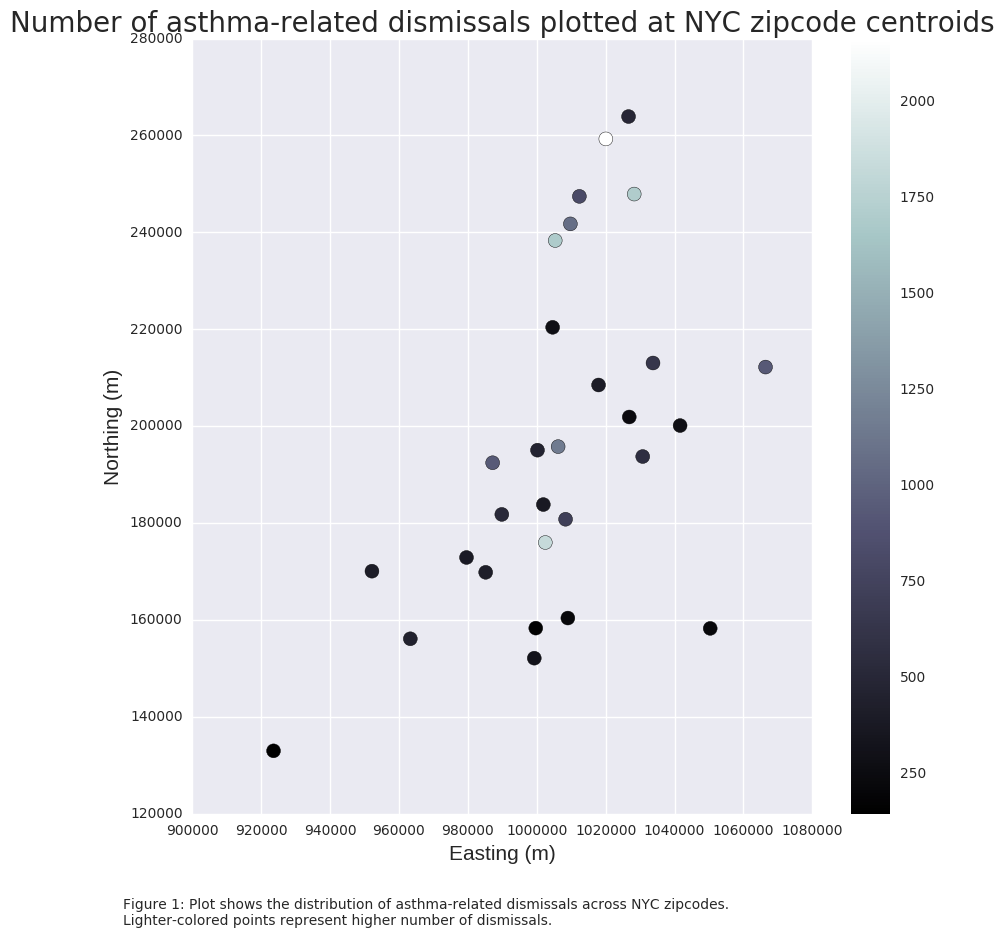

In [144]:
pl.figure(figsize = (10, 10))
pl.scatter(krigdata[:, 1], krigdata[:, 2], c = krigdata[:, 0], s = 100, cmap = 'bone')
pl.xlabel("Easting (m)", fontsize = 15)
pl.ylabel("Northing (m)", fontsize = 15)
pl.title('Number of asthma-related dismissals plotted at NYC zipcode centroids', fontsize = 20)
pl.text(880000, 97000, 'Figure 1: Plot shows the distribution of asthma-related dismissals across NYC zipcodes. \n\
Lighter-colored points represent higher number of dismissals.')
pl.colorbar()
pl.show()

#### Creating a semi-variogram

In [119]:
# Using code Federica provided
def SVh( P, h, bw ):
    '''
    Experimental semivariogram for a single lag
    bw max distance
    h lag
    P data
    '''
    #distance matrix (eucledian)
    pdsv = squareform( pdist( P[:,:2] ) )
    #print pdsv
    N = pdsv.shape[0]
    #print N

    Z = list()
    for i in range(N):
        for j in range(i+1, N):
            #select only pair of points at the appropriate lag
            if( pdsv[i,j] >= h - bw )and( pdsv[i,j] <= h + bw ):
                Z.append( ( P[i,2] - P[j,2] )**2.0 )
    #print Z
    return np.sum( Z ) / ( 2.0 * len( Z ) )


def SV( P, hs, bw ):
    '''
    Experimental variogram for a collection of lags
    '''
    sv = list()
    for h in hs:
        #print h
        sv.append( SVh( P, h, bw ) )
        #sv.append( SVh_vctzd ( P, h, bw ) )
    sv = [ [ hs[i], sv[i] ] for i in range( len( hs ) ) if sv[i] > 0 ]
    return np.array( sv ).T

In [145]:
# lags in 100 meter increments from zero to 10,000
lag = 100 
hs = np.arange(0, 10000, lag)
bw = 100

In [146]:
sv = SV(krigdata, hs, bw)

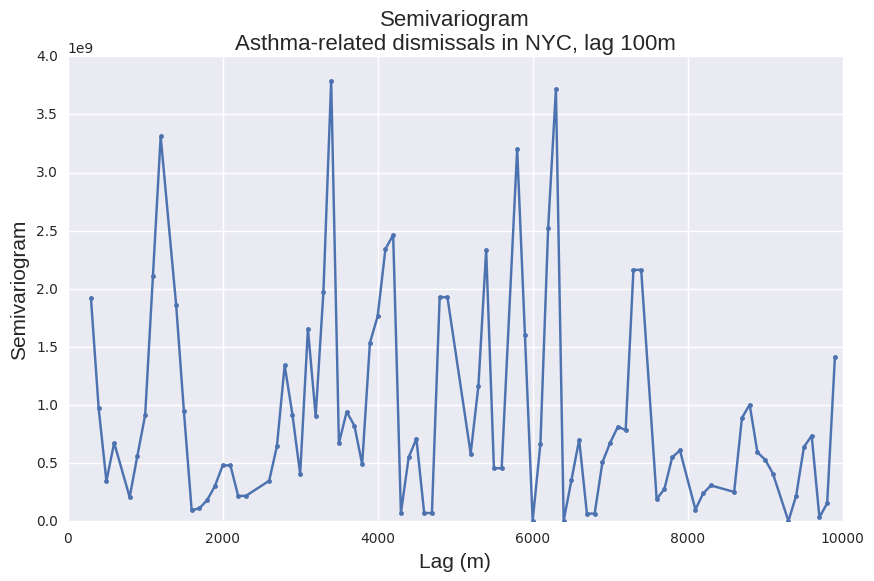

In [156]:
pl.figure(figsize = (10, 6))
plot(sv[0], sv[1], '.-' )
pl.xlabel('Lag (m)', fontsize = 15)
pl.ylabel('Semivariogram', fontsize = 15)
pl.title('Semivariogram\nAsthma-related dismissals in NYC, lag %dm'%lag, fontsize = 16) 
pl.show()

Figure 2. Based on the semivariogram, we observe no similarity in the number of asthma dismissals based on the distance between zipcodes where these dismissals occur.

#### Fitting a model to confirm no relationship

In [166]:
# Using code provided by Federica for different variogram models
def opt( fct, x, y, C0, meshSize=1000 ):
    parameterRange = [ x[1], x[-1] ]
    mse = np.zeros( meshSize )
    a = np.linspace( parameterRange[0], parameterRange[1], meshSize )
    for i in range( meshSize ):
        mse[i] = np.mean( ( y - fct( x, a[i], C0 ) )**2.0 )
    return a[ mse.argmin() ]        


def spherical( h, a, C0 ):
    #print "sph"

    '''
    Spherical model of the semivariogram
    '''
    # if h is a single digit

    
    if type(h) == np.float64:
        # calculate the spherical function
        if h <= a:
            return C0*( 1.5*h/a - 0.5*(h/a)**3.0 )
        else:
            return C0
    # if h is an iterable
    else:
        # calcualte the spherical function for all elements
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        return map( spherical, h, a, C0 )

def exponentialngt(h, a, C0):
    #print "exp"
    '''
    Exponential model of the semivariogram
    '''
    # if h is a single digit
    if type(h) == np.float64:
        # calculate the spherical function
        return C0 - exp(-h/a)
    # if h is an iterable
    else:
        # calcualte the spherical function for all elements
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        return map( exponentialngt, h, a, C0 )

    
def gaussianngt(h, a, C0):
    #print "gaus"
    '''
    Gaussian model of the semivariogram
    '''
    # if h is a single digit
    if type(h) == np.float64:
        # calculate the spherical function
        return C0 - exp(-(h/a)**2)
    # if h is an iterable
    else:
        # calcualte the spherical function for all elements
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        return map( exponentialngt, h, a, C0 )



def C( P, h, bw ):
    '''
    Calculate the sill
    '''
    c0 = np.var( P[:,2] )
    if h == 0:
        return c0
    return c0 - SVh( P, h, bw )



def cvmodel( P, model, hs, bw ):
    '''
    Input:  (P)      ndarray, data
            (model)  modeling function
                      - spherical
                      - exponentialngt
                      - gaussian
            (hs)     distances
            (bw)     bandwidth
    Output: (covfct) function modeling the covariance
    '''
    # calculate the semivariogram
    sv = SV( P, hs, bw )
    # calculate the sill
    C0 = C( P, hs[0], bw )
    #print C0
    # calculate the optimal parameters
    param = opt( model, sv[0], sv[1], C0 )
    # return a covariance function
    covfct = lambda h, a = param: C0 - model( h, a, C0 )
    return covfct

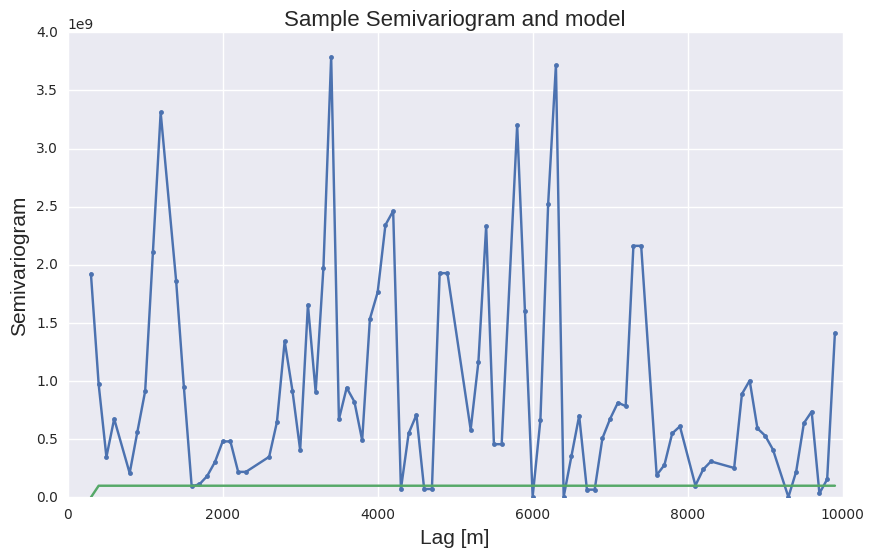

In [165]:
pl.figure(figsize=(10, 6))
sp = cvmodel(krigdata, model = spherical, hs = hs, bw = bw)
#print sp(mysv[0])
sphere = sp(sv[0])
plot(sv[0], sv[1], '.-' )
pl.plot(sv[0], -sphere+sphere.max())
pl.xlabel('Lag [m]', fontsize = 15)
pl.ylabel('Semivariogram', fontsize = 15)
pl.title('Sample Semivariogram and model', fontsize = 16)
pl.show()

Figure 3. Model semivariogram shows no relationship as expected. 